In [1]:
import tempfile
import time
import networkx as nx

from braket.aws import AwsQuantumJob, AwsSession

from braket.jobs.config import (
    InstanceConfig,
    OutputDataConfig,
    StoppingCondition
)
from braket.jobs.image_uris import Framework, retrieve_image

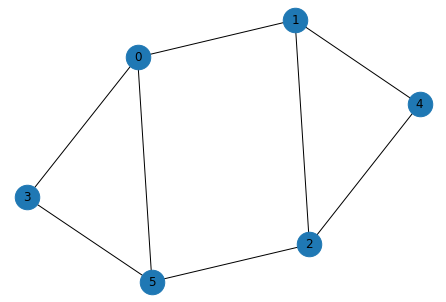

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of qubits, so each circuit will have runtime exponential in num_nodes
num_nodes = 6
num_edges = 8
seed = 1967
    
graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

In [3]:
# Pick 'autograd', 'tf', or 'torch'. Autograd is base PennyLane
interface = "autograd"
# Specify device that the job will primarily be targeting
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
# Specify previous job arn to copy checkpoints from, or None to not copy checkpoints
copy_checkpoints_from_job = None
# copy_checkpoints_from_job = "arn:aws:braket:<region>:<your-account-id>:job/<job-name>"

hyperparameters = {
    # Number of tasks per iteration = 2 * (num_nodes + num_edges) * p + 1
    "p": "2",
    "seed": str(seed),
    # Maximum number of simultaneous tasks allowed
    "max_parallel": "10",
    # Number of total optimization iterations, including those from previous checkpoint (if any)
    "num_iterations": "5",
    # Step size / learning rate for gradient descent
    "stepsize": "0.1",
    # Shots for each circuit execution
    "shots": "1000",
    "interface": interface,
}
if copy_checkpoints_from_job:
    hyperparameters['copy_checkpoints_from_job'] = copy_checkpoints_from_job

In [4]:
# Job data will be sent to this bucket by default,
# unless output_data_config is specified in the next cell.
aws_session = AwsSession()
bucket = aws_session.default_bucket()
print(bucket)

amazon-braket-your-bucket-name


In [5]:
# Other possible settings
# Uncomment or edit to vary
kwargs = {
#     "stopping_condition": StoppingCondition(maxRuntimeInSeconds=5 * 24 * 60 * 60),
#     "output_data_config": OutputDataConfig(s3Path="s3://amazon-braket-your-bucket-name/your-folder-name"),
#     "instance_config": InstanceConfig(instanceType="ml.m5.large"),
}

In [6]:
# Function to upload the graph to S3 in an adjacency list format
def setup_input_stream():
    with tempfile.NamedTemporaryFile() as temp_graph_file:
        # define the uri for our input data stream
        stream_s3_uri = aws_session.construct_s3_uri(
            aws_session.default_bucket(),
            "input-graph",
        )
        # Write graph to a temporary file
        nx.write_adjlist(graph, temp_graph_file.name)
        # Upload temporary file to S3
        aws_session.upload_to_s3(temp_graph_file.name, f"{stream_s3_uri}/input-data.adjlist")
    return stream_s3_uri

In [7]:
region = aws_session.region

# Choose the container based on which one we need.
if interface == 'autograd':
    # Base container does not have PennyLane, so we have to use the TF or PyTorch container
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'tf':
    image_uri = retrieve_image(Framework.PL_TENSORFLOW, region)
elif interface == 'torch':
    image_uri = retrieve_image(Framework.PL_PYTORCH, region)

In [8]:
start_time = time.time()

job = AwsQuantumJob.create(
    device_arn=device_arn,
    source_module="qaoa_source",
    # Any unique name works. Note 50-character limit in job name
    # (comment out to use default naming)
    job_name="JobTest-"+interface+"-"+str(int(time.time())),
    image_uri=image_uri,
    # Relative to the current location
    entry_point="qaoa_source.qaoa_algorithm_script:start_here",
    copy_checkpoints_from_job=copy_checkpoints_from_job,
    # general parameters
    hyperparameters=hyperparameters,
    input_data={
        "input-graph": setup_input_stream()
    },
    # Comment out the following line if you want to run the job
    # silently and asynchronously
    wait_until_complete=True,
    **kwargs
)

end_time = time.time()

Initializing Braket Job: arn:aws:braket:<region>:<account-id>:job/<job-name>
.............................................
2021-09-17 20:32:29.279644: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-09-17 20:32:29.288260: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-09-17 20:32:29.467426: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-09-17 20:32:33,611 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-09-17 20:32:33,611 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2021-09-17 20:32:33,618 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-17 20:32:33,633 sa

In [9]:
print(end_time - start_time)

414.83807706832886


In [10]:
print(job.arn)

arn:aws:braket:<region>:<account-id>:job/<job-name>


In [11]:
print(job.metadata())

{'ResponseMetadata': {'RequestId': '5790ec29-96fd-4e08-bbfa-f4f3040b1464', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Fri, 17 Sep 2021 20:35:20 GMT', 'content-type': 'application/json', 'content-length': '2188', 'connection': 'keep-alive', 'x-amzn-requestid': '5790ec29-96fd-4e08-bbfa-f4f3040b1464', 'access-control-allow-origin': '*', 'strict-transport-security': 'max-age=63072000; includeSubDomains; preload', 'access-control-allow-headers': '*,authorization,date,x-amz-date,x-amz-security-token,x-amz-target,content-type,x-amz-content-sha256,x-amz-user-agent,x-amzn-platform-id,x-amzn-trace-id', 'x-amz-apigw-id': 'F0xRaEumPHcF8lA=', 'access-control-allow-methods': 'OPTIONS,GET,PUT,POST,DELETE', 'access-control-expose-headers': 'x-amzn-errortype,x-amzn-requestid,x-amzn-errormessage,x-amzn-trace-id,x-amz-apigw-id,date', 'x-amzn-trace-id': 'Root=1-6144fc08-56a43ae6329f40fb217872eb'}, 'RetryAttempts': 0}, 'algorithmSpecification': {'containerImage': {'uri': '292282985366.dkr.ecr.region.a

In [12]:
print(job.result())

{'params': [[0.08120119576374078, 0.3497812068052205], [-0.023551388020882538, -0.5295198990587167]], 'cost': -4.804}


In [13]:
# May need to wait a bit before metrics show up
# If metrics aren't there, run a bit later
time.sleep(120)
print(job.metrics())

{'timestamp': [1631910897.0831287, 1631910894.433991, 1631910871.8427947, 1631910848.5363865, 1631910824.6020079, 1631910801.3858464], 'Cost': [-4.804, -4.314, -4.049, -3.995, -4.007, -4.01], 'iteration_number': [5.0, 4.0, 3.0, 2.0, 1.0, 0.0]}


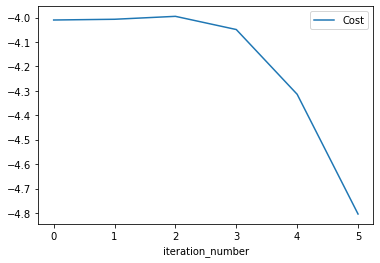

In [14]:
# A demonstration of plotting the metrics

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd

df = pd.DataFrame(job.metrics())

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x='iteration_number', y='Cost', ax=ax)

In [15]:
# Run this cell to reprint logs from CloudWatch
job.logs()


2021-09-17 20:32:29.279644: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-09-17 20:32:29.288260: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2021-09-17 20:32:29.467426: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2021-09-17 20:32:33,611 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2021-09-17 20:32:33,611 sagemaker-training-toolkit INFO     Failed to parse hyperparameter interface value autograd to Json.
Returning the value itself
2021-09-17 20:32:33,618 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-17 20:32:33,633 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-09-17 20:32:33,634 sagemaker-trainin

In [16]:
# Downloads results to current directory
job.download_result()